# Reproduce our plots

This notebook can reproduce the plots showed in our paper.

## 0. Install and load required packages

In [1]:
for(pkg in c("dplyr","tidyr", "ggplot2", "ggsci","ggrepel", "ggpubr", "patchwork", "umap", "rstatix")) {
    if(!require(pkg, character.only = TRUE)) {
        print(paste("installing package:", pkg))
        install.packages(pkg)
    }
    library(pkg, character.only = TRUE)
}

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: ggsci

Loading required package: ggrepel

Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Loading required package: patchwork

Warning message:
"package 'patchwork' was built under R version 4.2.3"
Loading required package: umap

Loading required package: rstatix

Warning message:
"package 'rstatix' was built under R version 4.2.3"

Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter




## 1. Plots for performance evaluation

### 1.1 Boxplots for percent bias (PB)
#### Process imputed data and compute PB values
    
Load observed and imputed data, and then compute PB values. Here, we use the imputed data stored in "data/MGH_COVID_imputed" as an example to show how we compute PB. You can get the imputed data by running "example.py"

In [2]:
# path for imputed data and observed data
observed_path_MGH <- "data/MGH_COVID/vB_t2_observed.csv"
imputation_dir_MGH <- "data/MGH_COVID_imputed"
obsNum_names <- c("obsNum=0", "obsNum=25", "obsNum=50", "obsNum=100")
method_names <- c("LEOPARD", "cGAN", "missForest", "PMM", "LM_GLMM")

# function for computing PB
compute_PB <- function(observed_data, imputation_data) {
    PB_values <- abs(imputation_data - observed_data) / (abs(observed_data) + 1e-16)
    median_PB <- apply(PB_values, 2, median, na.rm = TRUE)
    median_PB
}

# function for loading data and computing PB
process_PB_data <- function(imputation_dir, observed_path, obsNum_names, method_names) {
    message("+ load data and compute PB...")
    observed_data <- read.table(observed_path, header = TRUE, sep = ",")
    observed_data[c("label", "zz_nr")] <- NULL

    obsNum_data <- lapply(obsNum_names, function(current_obsNum, method_names, observed_data, imputation_dir) {
        message("  - ", current_obsNum)

        PB_method <- lapply(method_names, function(current_method, observed_data, imputation_dir, current_obsNum) {
            message("    - method: ", current_method)
            
            if (current_method %in% c("PMM", "LM_GLMM")) {
                imputationFolder <- file.path(imputation_dir, current_obsNum, current_method)
                multiple_PB <- lapply(dir(imputationFolder, full.names = TRUE), function(current_imputation_path) {
                    current_imputation <- read.table(current_imputation_path, sep = ",", header = TRUE)
                    current_PB <- compute_PB(observed_data = observed_data, imputation_data = current_imputation)
                })
                average_PB  <- Reduce("+", multiple_PB) / length(multiple_PB)
                out <- data.frame(method = current_method, PB = average_PB, var_name = names(average_PB))
            } else {
                imputation_path <- file.path(imputation_dir, current_obsNum, paste0(current_method, ".csv"))
                imputation_data <- read.table(imputation_path, sep = ",", header = TRUE)
                imputation_PB <- compute_PB(observed_data = observed_data, imputation_data = imputation_data)
                out <- data.frame(method = current_method, PB = imputation_PB, var_name = names(imputation_PB))
            }
            out
        }, observed_data = observed_data, imputation_dir = imputation_dir, current_obsNum = current_obsNum)

        PB_method_df <- cbind(obsNum = current_obsNum, do.call("rbind", PB_method))

    }, method_names = method_names, observed_data = observed_data, imputation_dir = imputation_dir)

    obsNum_data_df <- do.call("rbind", obsNum_data)
    row.names(obsNum_data_df) <- NULL

    obsNum_data_df
}

We use the following function to generate boxplots.

In [3]:
# function for generating boxplot

format_PB_input <- function(input_plotData){
    # format method order in the plot
    input_plotData[["method"]] <- factor(input_plotData[["method"]], 
                                         levels = c("LEOPARD", "cGAN", "missForest", "PMM", "LM_GLMM"))
    
    # format obsNum order in the plot
    obsNum_values <- unique(input_plotData[["obsNum"]])
    obsNum_numeric_part <- as.numeric(gsub("obsNum=", "", obsNum_values, fixed = TRUE))
    obsNum_values_sorted <- obsNum_values[order(obsNum_numeric_part)]
    input_plotData[["obsNum"]] <- factor(input_plotData[["obsNum"]], levels = obsNum_values_sorted)
    input_plotData
}


#### MGH COVID dataset

In [4]:
# process the imputed data for MGH COVID dataset
raw_PB_MGH <- process_PB_data(imputation_dir = imputation_dir_MGH, observed_path = observed_path_MGH,
                              obsNum_names = obsNum_names, method_names = method_names)
# set factor
PB_MGH <- format_PB_input(raw_PB_MGH)

+ load data and compute PB...

  - obsNum=0

    - method: LEOPARD

    - method: cGAN

    - method: missForest

    - method: PMM

    - method: LM_GLMM

  - obsNum=25

    - method: LEOPARD

    - method: cGAN

    - method: missForest

    - method: PMM

    - method: LM_GLMM

  - obsNum=50

    - method: LEOPARD

    - method: cGAN

    - method: missForest

    - method: PMM

    - method: LM_GLMM

  - obsNum=100

    - method: LEOPARD

    - method: cGAN

    - method: missForest

    - method: PMM

    - method: LM_GLMM



In [5]:
options(repr.plot.width = 16, repr.plot.height = 4)

# compute median value of each box
medians_MGH <- PB_MGH %>% 
    group_by(method, obsNum) %>%
    summarise(median_PB = median(PB, na.rm = TRUE), .groups = 'drop')

# compute significance level
sigLevel_MGH <- PB_MGH %>%
    group_by(obsNum) %>%
    rstatix::wilcox_test(PB ~ method, paired = TRUE, ref.group = "LEOPARD",
                         p.adjust.method = "bonferroni") %>%
    rstatix::add_significance(cutpoints = c(0, 0.001, 0.01, 0.05, 1),
                              symbols = c("***", "**", "*", "ns")) %>% 
    rstatix::add_xy_position(x = "method", step.increase = 0.8, y.trans = log10)

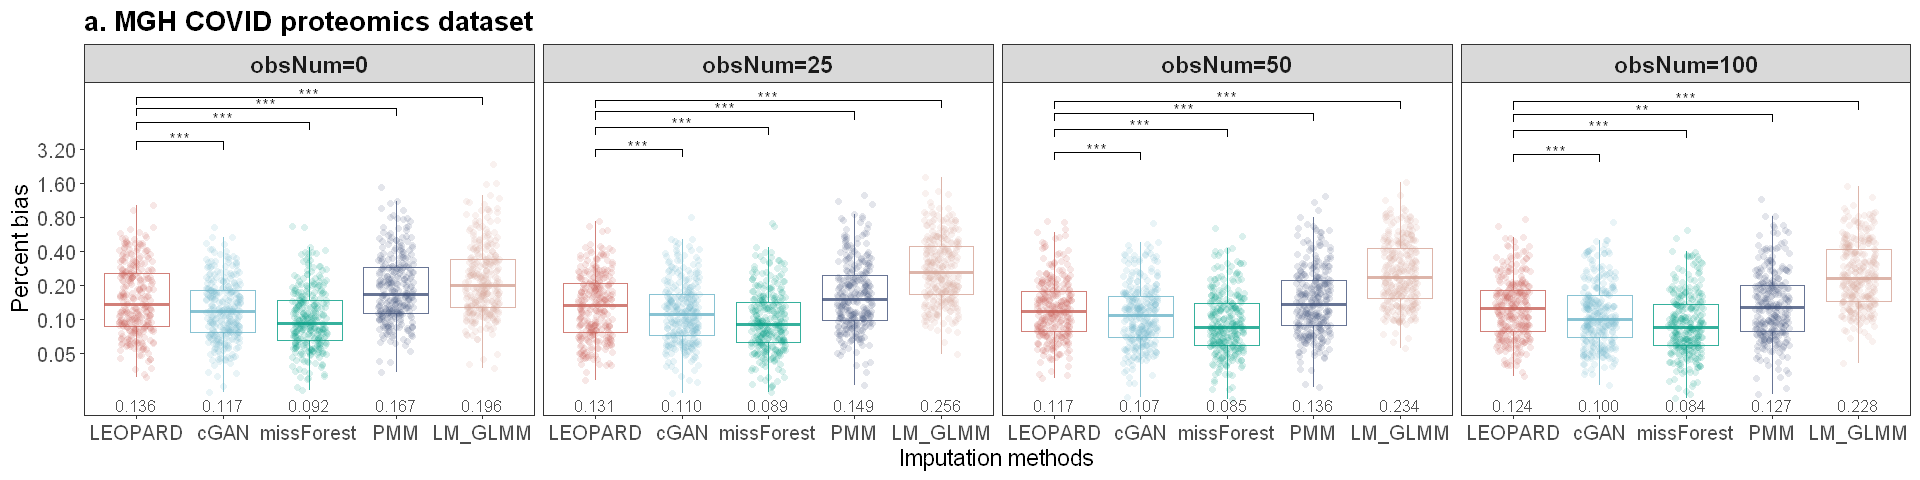

In [6]:
ggplot(data = PB_MGH, aes(x = method, y = PB, colour = method)) +
    geom_boxplot(outlier.colour = "black", outlier.shape = NA, notch = F) +
    # geom_violin(alpha = I(0.5), trim = F, colour = "gray", fill = NA, scale = "count") + # add violin plot?
    geom_jitter(alpha = I(0.15), shape = 16, width = 0.2) + 
    geom_text(data = medians_MGH, aes(x = method, y = 0.02, label = sprintf("%.3f", median_PB)),
              color = rgb(0.2, 0.2, 0.2, 0.85), size = 3.5, vjust = 1) +
    ggpubr::stat_pvalue_manual(sigLevel_MGH) +
    scale_y_continuous(breaks = c(0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2), trans = "log10") +
    facet_wrap(~ obsNum, scales = "fixed", drop = TRUE, nrow = 1) +
    theme_bw() +
    theme(legend.position = 'none',
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(), # comment this line to show grid for y-axis
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12),
          legend.title = element_text(size = 14),
          strip.text   = element_text(size = 14, face = "bold")) +
    guides(col = guide_legend(nrow = 1)) +
    xlab("Imputation methods") +
    ylab("Percent bias") +
    ggtitle("a. MGH COVID proteomics dataset") +
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(5), 0.02))

#### KORA metabolomics dataset

The KORA data and any data derived from it are bound by various rules and data protection laws, 
so we cannot share the raw or imputed data publicly. 
We made the boxplots using the PB values, which are calculated the same way as we did for the MGH COVID dataset (descibed above). 
You can find the PB values calculated for the KORA datasets in the "data/plotData" folder.

In [7]:
# load PB values of the KORA metabolomics dataset
raw_PB_koraMeta <- read.table("data/plotData/evaluation_PB_koraMeta.csv", sep = ",", header = TRUE)

# set factor
PB_koraMeta <- format_PB_input(raw_PB_koraMeta)

# compute median value of each box
medians_koraMeta <- PB_koraMeta %>% 
    group_by(method, obsNum) %>%
    summarise(median_PB = median(PB, na.rm = TRUE), .groups = 'drop')

# add significance level
sigLevel_koraMeta <- PB_koraMeta %>%
    group_by(obsNum) %>%
    rstatix::wilcox_test(PB ~ method, paired = TRUE, ref.group = "LEOPARD",
                         p.adjust.method = "bonferroni") %>%
    rstatix::add_significance(cutpoints = c(0, 0.001, 0.01, 0.05, 1),
                              symbols = c("***", "**", "*", "ns")) %>% 
    rstatix::add_xy_position(x = "method", step.increase = 0.8, y.trans = log10)

Warning message:
"Removed 8 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 8 rows containing missing values or values outside the scale range (`geom_point()`)."


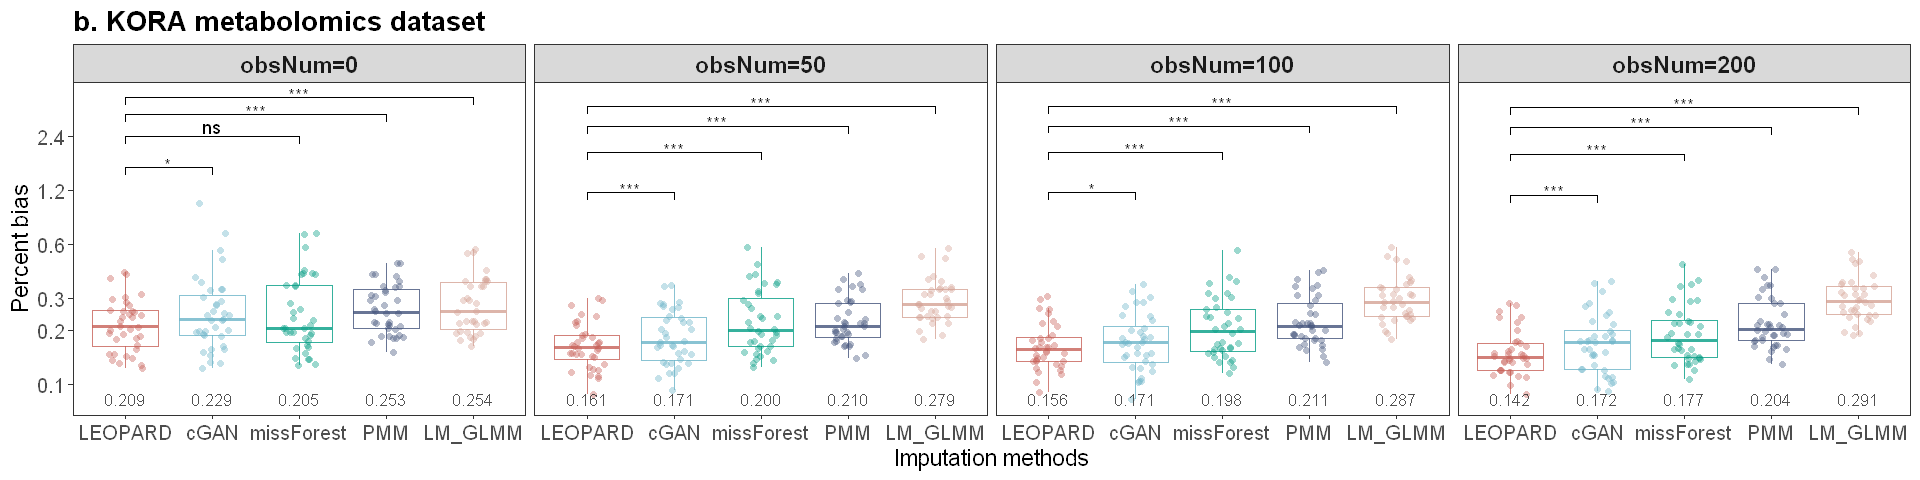

In [8]:
# eight NA values: invalid imputation for variables (C14:1-OH and C16:2), by GLMM under four different obsNum

ggplot(data = PB_koraMeta, aes(x = method, y = PB, colour = method)) +
    geom_boxplot(outlier.colour = "black", outlier.shape = NA, notch = F) +
    # geom_violin(alpha = I(0.5), trim = F, colour = "gray", fill = NA, scale = "count") + # add violin plot?
    geom_jitter(alpha = I(0.4), shape = 16, width = 0.2) + 
    geom_text(data = medians_koraMeta, aes(x = method, y = 0.09, label = sprintf("%.3f", median_PB)),
              color = rgb(0.2, 0.2, 0.2, 0.85), size = 3.5, vjust = 1) +
    ggpubr::stat_pvalue_manual(sigLevel_koraMeta) +
    scale_y_continuous(breaks = c(0.1, 0.2, 0.3, 0.6, 1.2, 2.4), trans = "log10") +
    facet_wrap(~ obsNum, scales = "fixed", drop = TRUE, nrow = 1) +
    theme_bw() +
    theme(legend.position = 'none',
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(), # comment this line to show grid for y-axis
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12),
          legend.title = element_text(size = 14),
          strip.text   = element_text(size = 14, face = "bold")) +
    guides(col = guide_legend(nrow = 1)) +
    xlab("Imputation methods") +
    ylab("Percent bias") +
    ggtitle("b. KORA metabolomics dataset") +
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(5), 0.02))


#### KORA multi-omics dataset

In [9]:
# load PB values of the KORA metabolomics dataset
raw_PB_koraMulti <- read.table("data/plotData/evaluation_PB_koraMulti.csv", sep = ",", header = TRUE)

# set factor
PB_koraMulti <- format_PB_input(raw_PB_koraMulti)

# compute median value of each box
medians_koraMulti <- PB_koraMulti %>% 
    group_by(method, obsNum) %>%
    summarise(median_PB = median(PB, na.rm = TRUE), .groups = 'drop')

# add significance level
sigLevel_koraMulti <- PB_koraMulti %>%
    group_by(obsNum) %>%
    rstatix::wilcox_test(PB ~ method, paired = TRUE, ref.group = "LEOPARD",
                         p.adjust.method = "bonferroni") %>%
    rstatix::add_significance(cutpoints = c(0, 0.001, 0.01, 0.05, 1),
                              symbols = c("***", "**", "*", "ns")) %>% 
    rstatix::add_xy_position(x = "method", step.increase = 0.25, y.trans = function(x){log(x+1)})

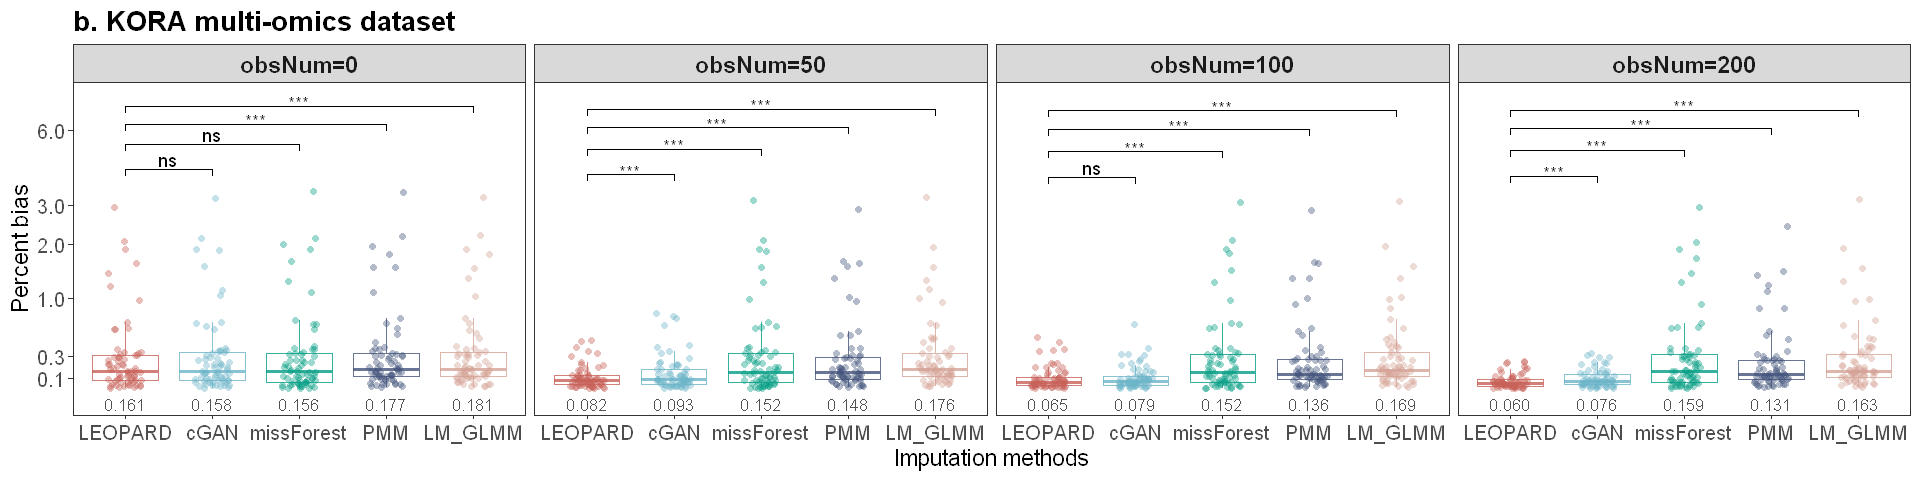

In [10]:
# eight NA values: invalid imputation for variables (C14:1-OH and C16:2), by GLMM under four different obsNum

ggplot(data = PB_koraMulti, aes(x = method, y = PB, colour = method)) +
    geom_boxplot(outlier.colour = "black", outlier.shape = NA, notch = F) +
    # geom_violin(alpha = I(0.5), trim = F, colour = "gray", fill = NA, scale = "count") + # add violin plot?
    geom_jitter(alpha = I(0.4), shape = 16, width = 0.2) + 
    geom_text(data = medians_koraMulti, aes(x = method, y = 0.00, label = sprintf("%.3f", median_PB)),
              color = rgb(0.2, 0.2, 0.2, 0.85), size = 3.5, vjust = 1.5) +
    ggpubr::stat_pvalue_manual(sigLevel_koraMulti) +
    scale_y_continuous(breaks = c(1:3, 0.1, 0.3, 6), trans = "log1p", expand = c(0.06,0.05)) +
    facet_wrap(~ obsNum, scales = "fixed", drop = TRUE, nrow = 1) +
    theme_bw() +
    theme(legend.position = 'none',
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(), # comment this line to show grid for y-axis
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12),
          legend.title = element_text(size = 14),
          strip.text   = element_text(size = 14, face = "bold")) +
    guides(col = guide_legend(nrow = 1)) +
    xlab("Imputation methods") +
    ylab("Percent bias") +
    ggtitle("b. KORA multi-omics dataset") +
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(5), 0.02))

### 1.2 UMAP embeddings
#### Train UMAP model and embed raw/inputed data
    
Again, we use the imputed data stored in "data/MGH_COVID_imputed" to illustrate how we train a UMAP model and apply it to the observed and imputed data.

In [11]:
# specify path for data to be loaded 
method_names <- c("LEOPARD", "cGAN", "missForest", "PMM", "LM_GLMM")

imputation_time2_dir_MGH <- "data/MGH_COVID_imputed/obsNum=100"

train_path_MGH <- "data/MGH_COVID/vB_train.csv"
test_path_MGH <- "data/MGH_COVID/vB_test.csv"

# function for loading data and generating UMAP embeddings
# In our study, the loaded training data is randomly split to training set and validation set
# UMAP model is only trained with the training set and then applied to observed and imputed data from test data
# As data split is done randomly, here we use all training data to train UMAP model as an example.

process_umap_data <- function(train_path_MGH, test_path_MGH,
                              imputation_time2_dir_MGH, method_names,
                              umap_config = umap::umap.defaults) {

    message("+ load data...")
    train_data <- read.table(train_path_MGH, header = TRUE, sep = ",")
    train_data[c("label", "zz_nr")] <- NULL

    test_data <- read.table(test_path_MGH, header = TRUE, sep = ",")
    test_data <- cbind(source = ifelse(test_data$label == "D0", "Observed data (t1)", "Observed data (t2)"), 
                       test_data)
    test_data[c("label", "zz_nr")] <- NULL

    message("+ train UMAP model...")
    train_data_scaled <- scale(train_data)
    umap_config[["n_epochs"]] <- 800
    umap_model <- umap::umap(train_data_scaled, config = umap_config)

    message("+ process data imputed by:")
    umap_method <- lapply(method_names, function(current_method, imputation_time2_dir_MGH, test_data, 
                                                 scaled_center, scaled_scale, umap_model) {
        message("  - ", current_method)
        if (current_method %in% c("PMM", "LM_GLMM")) {
                imputationFolder <- file.path(imputation_time2_dir_MGH, current_method)
                multi_imputation <- lapply(dir(imputationFolder, full.names = TRUE), 
                                           function(current_imputation_path) {
                    current_imputation <- read.table(current_imputation_path, sep = ",", header = TRUE)
                })
                imputation_data  <- Reduce("+", multi_imputation) / length(multi_imputation)
        } else {
            imputation_path <- file.path(imputation_time2_dir_MGH, paste0(current_method, ".csv"))
            imputation_data <- read.table(imputation_path, sep = ",", header = TRUE)
        }
        imputation_data <- cbind(source = "Imputed data (t2)", imputation_data)
        umap_input_data <- rbind(test_data, imputation_data)
        
        umap_input_data_center <- sweep(as.matrix(umap_input_data[!names(umap_input_data) %in% "source"]),
                                        2, scaled_center, "-")
        umap_input_data_scaled <- sweep(umap_input_data_center, 2, scaled_scale, "/")
        umap_output_data <- as.data.frame(predict(umap_model, umap_input_data_scaled))
        current_method_ <- ifelse(current_method == "LM_GLMM", "GLMM", current_method)
        umap_output_data <- cbind(group = current_method_, 
                                  source = umap_input_data[["source"]], 
                                  umap_output_data)
    }, umap_model = umap_model, 
       imputation_time2_dir_MGH = imputation_time2_dir_MGH,
       test_data = test_data,
       scaled_center = attr(train_data_scaled, "scaled:center"), 
       scaled_scale  = attr(train_data_scaled, "scaled:scale"))

    umap_method_df <- do.call("rbind", umap_method)
    
    message("+ Complete.")
    umap_method_df
}

# generate UMAP embeddings for MGH COVID dataset
umap_MGH <- process_umap_data(train_path_MGH = train_path_MGH,
                              test_path_MGH = test_path_MGH,
                              imputation_time2_dir_MGH = imputation_time2_dir_MGH,
                              method_names = method_names)

+ load data...

+ train UMAP model...

+ process data imputed by:

  - LEOPARD

  - cGAN

  - missForest

  - PMM

  - LM_GLMM

+ Complete.



We use the following function to visualize UMAP embeddings.

In [12]:
generate_umap_plot <- function(input_plotData, point_size = 1, point_alpha = I(0.9), title = "") {
    # format method order in the plot
    input_plotData[["group"]]  <- factor(input_plotData[["group"]], 
                                         levels = c("LEOPARD", "cGAN", "missForest", "PMM", "GLMM"))
    
    # format data source order in the plot
    input_plotData[["source"]] <- factor(input_plotData[["source"]],
                                         levels = c("Observed data (t1)", "Observed data (t2)", "Imputed data (t2)"))
    
    # visualize UMAP embeddings
    plot_umap <- ggplot(data = input_plotData, aes(x = V1, y = V2, color = source))+
        geom_point(shape = 16, alpha = point_alpha, size = point_size) +
        # stat_ellipse(aes(colour = source), linewidth = 0.4, alpha = 0.9, lty = 2) + # add ellipse?
        facet_wrap(~ group, scales = "fixed", nrow = 1) +
        scale_colour_manual(values = c(pal_nejm("default", alpha = 0.55)(1),
                                       pal_npg("nrc", alpha = 0.55)(3)[3],
                                       pal_npg("nrc", alpha = 0.7)(4)[4])) +
        theme_bw() +
        scale_y_continuous(expand = expansion(c(0.1, 0.1))) +
        scale_x_continuous(expand = expansion(c(0.1, 0.1))) +
        theme(legend.position = "bottom",
              panel.grid.minor.x = element_blank(),
              panel.grid.minor.y = element_blank(),
              panel.grid.major.x = element_blank(),
              panel.grid.major.y = element_blank(),
              axis.ticks   = element_blank(),
              plot.title   = element_text(size = 16, face = "bold"),
              axis.text.x  = element_blank(),
              axis.text.y  = element_blank(),
              axis.title.y = element_text(size = 14),
              axis.title.x = element_text(size = 14),
              legend.text  = element_text(size = 12),
              legend.title = element_blank(),
              legend.background = element_blank(),
              legend.box.background = element_rect(color = "black", linewidth = 0.25),
              strip.text = element_text(size = 14, face = "bold")) +
        guides(col = guide_legend(nrow = 1)) +
        labs(x = "UMAP1", y = "UMAP2") +
        ggtitle(title)
    
    plot_umap
}

#### MGH COVID dataset

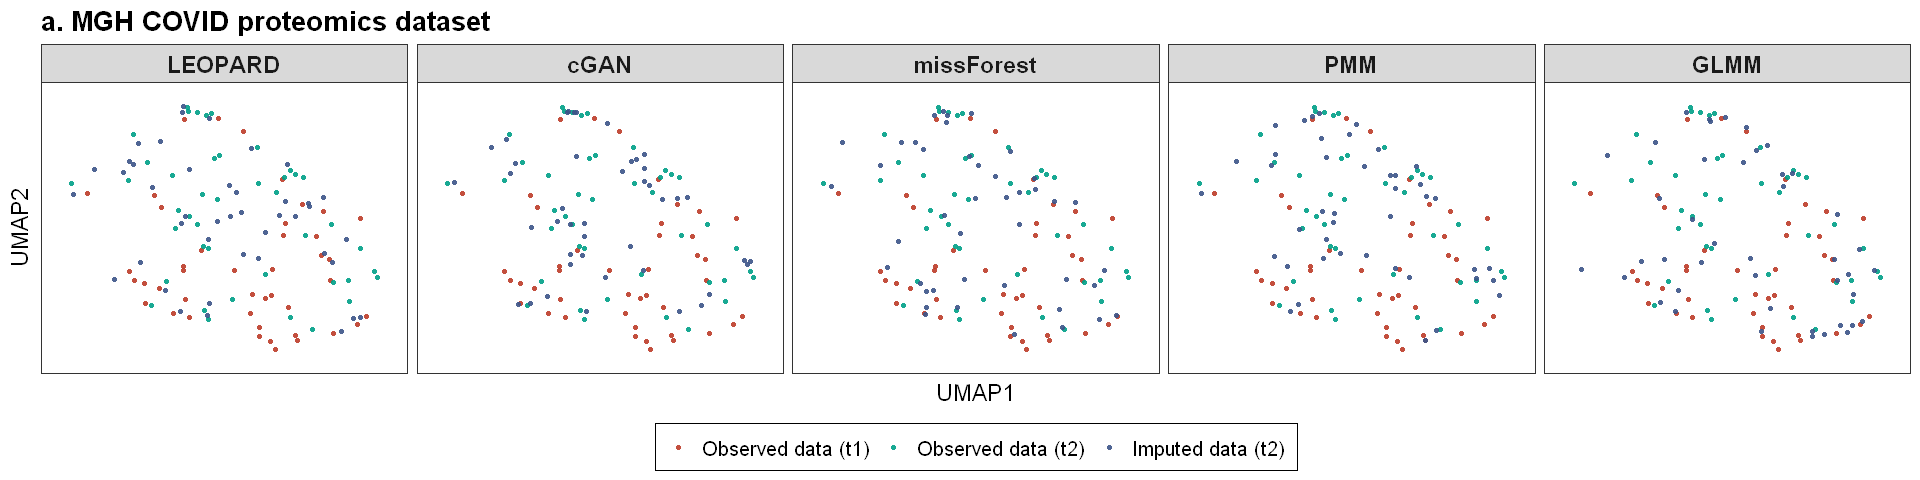

In [13]:
options(repr.plot.width = 16, repr.plot.height = 4)

plot_umap_MGH <- generate_umap_plot(input_plotData = umap_MGH, 
                                    point_size = 1, point_alpha = I(0.9), 
                                    title = "a. MGH COVID proteomics dataset")

# The plot may vary slightly with each run due to the stochastic mechanisms involved.
plot_umap_MGH

#### KORA metabolomics dataset

The UMAP embeddings of the KORA datasets have been saved in the "data/plotData" folder. Here we directly load the data and generate the plot. The UMAP model is trained with the training set, where the validation data are not included.

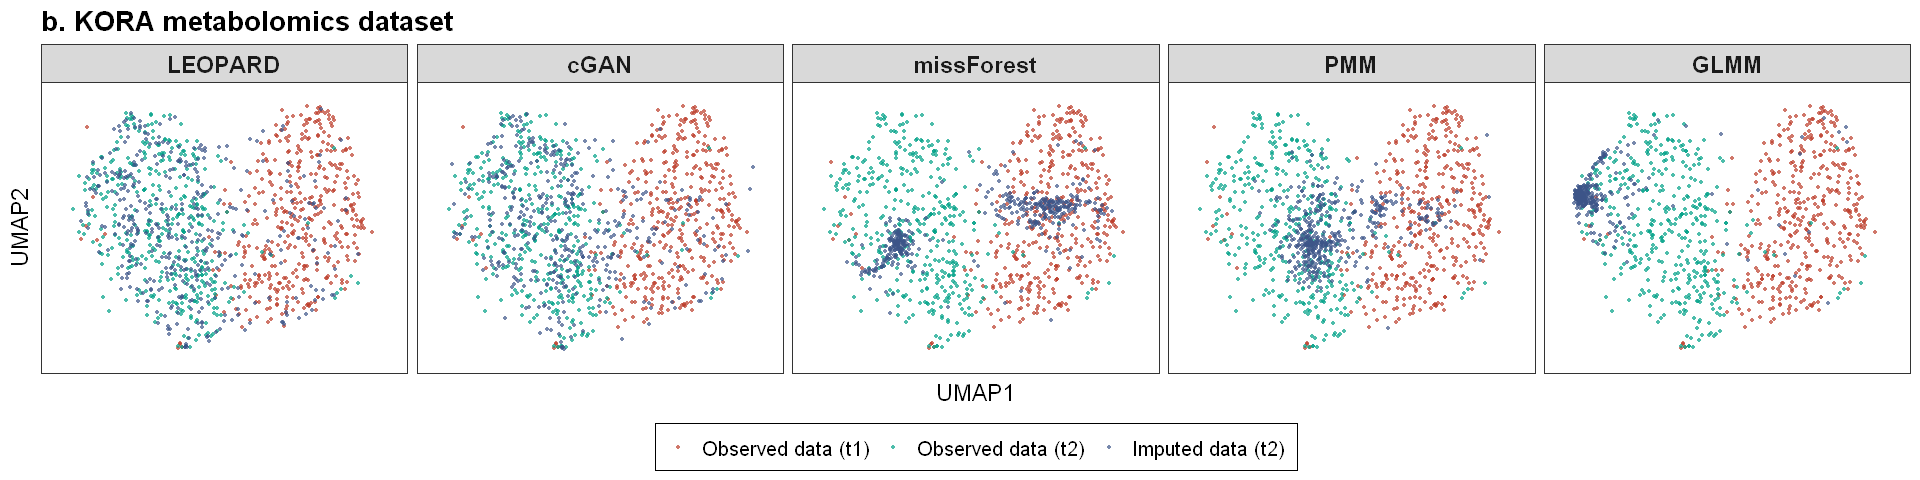

In [14]:
# load UMAP embeddings of the KORA metabolomics dataset
umap_koraMeta <- read.table("data/plotData/evaluation_umap_koraMeta.csv", sep = ",", header = TRUE)

# visualize UMAP embeddings
plot_umap_koraMeta <- generate_umap_plot(input_plotData = umap_koraMeta,
                                         point_size = 0.7, point_alpha = I(0.7),  
                                         title = "b. KORA metabolomics dataset")
plot_umap_koraMeta

#### KORA multi-omics dataset

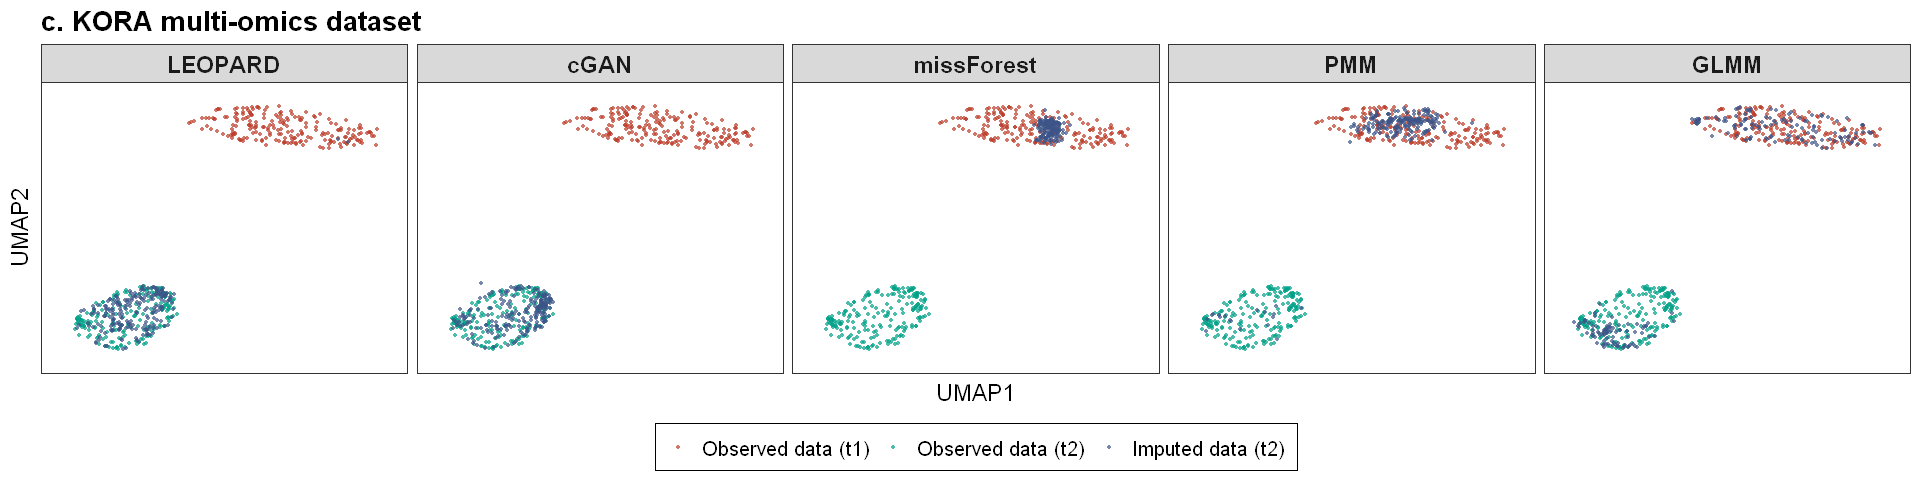

In [15]:
# load UMAP embeddings of the KORA multi-omics dataset
umap_koraMulti <- read.table("data/plotData/evaluation_umap_koraMulti.csv", sep = ",", header = TRUE)

# visualize UMAP embeddings
plot_umap_koraMulti <- generate_umap_plot(input_plotData = umap_koraMulti, 
                                          point_size = 0.7, point_alpha = I(0.7), 
                                          title = "c. KORA multi-omics dataset")
plot_umap_koraMulti

## 2. Plots for case studies

We use data saved in "data/plotData" to reproduce the plots in case study section

### 2.1 Regression analysis

#### age-associated metabolites identification with KORA metabolomics dataset

Regression model is fitted by formula: 
`one_metabolite_concentration ~ age + sex`

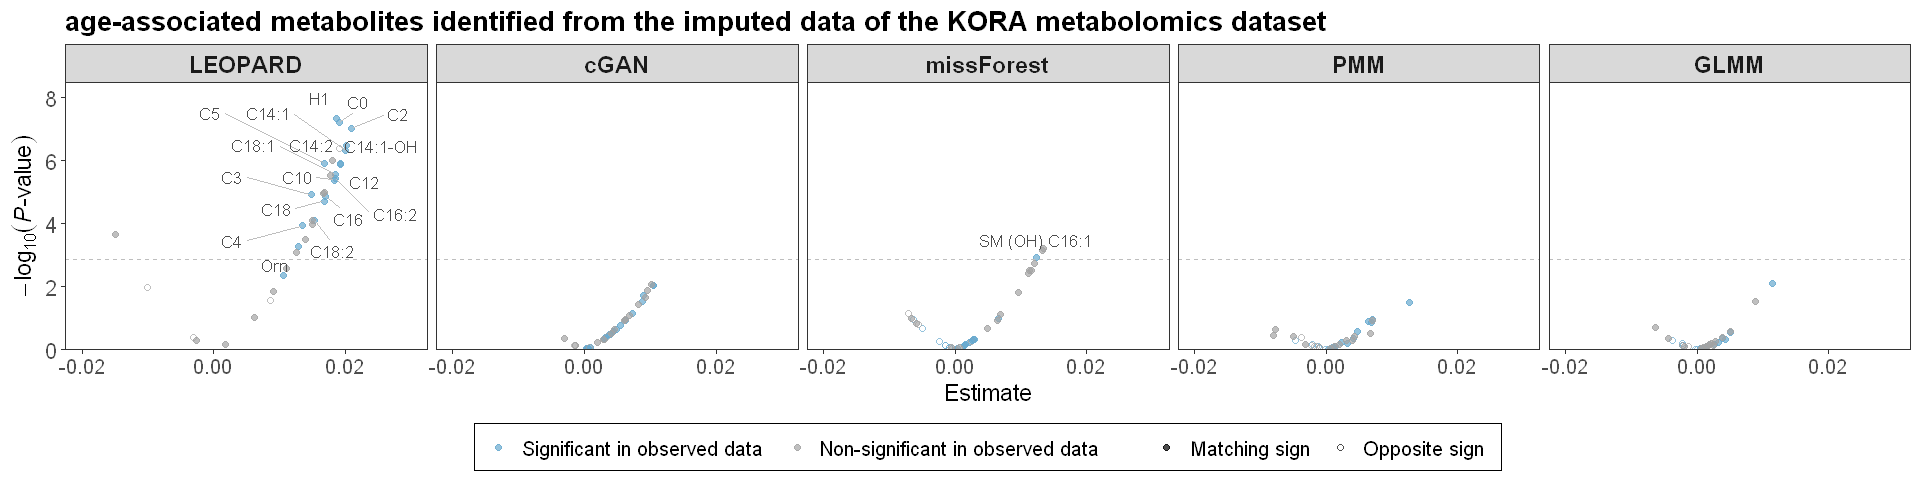

In [16]:
options(repr.plot.width = 16, repr.plot.height = 4)
options(ggrepel.max.overlaps = Inf)

# load estimate and P-val data
regression_koraMeta <- read.csv("data/plotData/caseStudy_regression_koraMeta.csv")
regression_koraMeta[["Method"]] <- factor(regression_koraMeta[["Method"]],
                                          levels = c("LEOPARD", "cGAN", "missForest", "PMM", "GLMM"))
regression_koraMeta[["Bonferroni_observedData"]] <- factor(regression_koraMeta[["Bonferroni_observedData"]],
                                                           levels = c("Significant in observed data", 
                                                                      "Non-significant in observed data"))

# generate volcano plot
plot_volcano_age <- ggplot(regression_koraMeta, aes(x = Estimate, y = -log10(P), 
                                                    color = Bonferroni_observedData,
                                                    label = Response)) +
    geom_point(alpha = I(0.7), size=1.5, aes(shape=factor(Sign_agreement))) +
    geom_hline(yintercept = (-log10(0.05/36)), linetype = 2, color = "grey") +
    scale_color_manual(values = c("#67a9cf", "#A3A3A3"), guide = guide_legend(order = 1)) +
    scale_shape_manual(values = c(19,1)) +
    facet_wrap(~ Method, nrow = 1, scales = "fixed") +
    labs(x = "Estimate", y = expression(-log[10](italic("P")*textstyle("-")*value))) +
    geom_label_repel(data = regression_koraMeta[regression_koraMeta[["Bonferroni_observedData"]] == 
                                                "Significant in observed data" &
                                                regression_koraMeta[["Bonferroni"]],],
                     size = 3.5, color = "grey30", box.padding = 0.2, label.padding = 0.2,
                     segment.color = 'gray', segment.size = 0.5,
                     nudge_y = 0.15, label.size = NA, fill = NA, ylim = c(0,8.5)) +
    scale_x_continuous(expand = c(0.05, 0),  limits = c(-0.02, 0.03), breaks = seq(-0.02, 0.04, 0.02)) +
    scale_y_continuous(expand = c(0.0, 0.0), limits = c(0, 8.5)) +
    theme_bw() +
    theme(legend.position = 'bottom',
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 13),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12, face = 'plain'),
          strip.text   = element_text(size = 14, face = "bold"),
          legend.title = element_blank(),          
          legend.background = element_blank(),
          legend.box.background = element_rect(color = "black", linewidth = 0.25),
          legend.key = element_rect(fill = NA)) +
    ggtitle("age-associated metabolites identified from the imputed data of the KORA metabolomics dataset")

plot_volcano_age

### Regression analysis: eGFR-associated proteins identification with KORA multi-omics dataset

Regression model is fitted by formula: 
`eGFR ~ one_protein_npx + age + sex`

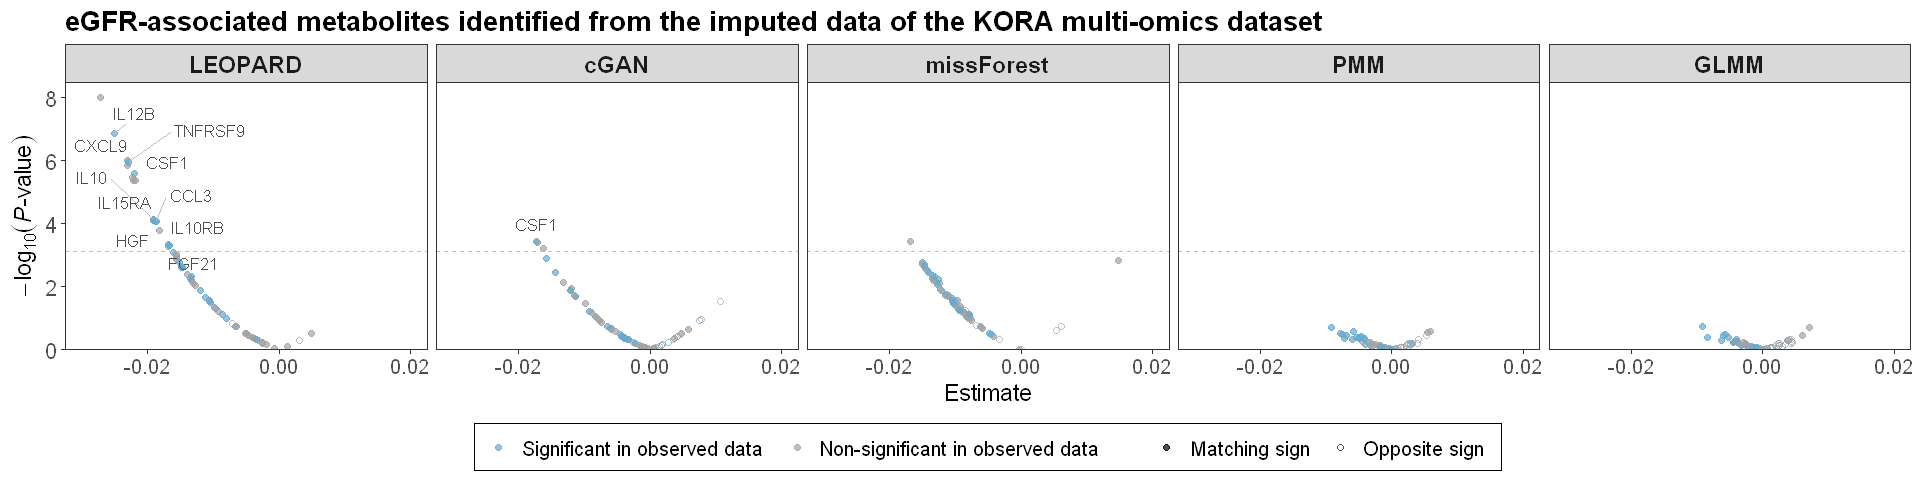

In [17]:
# load estimate and P-val data
regression_koraMulti <- read.csv("data/plotData/caseStudy_regression_koraMulti.csv")
regression_koraMulti[["Method"]] <- factor(regression_koraMulti[["Method"]],
                                           levels = c("LEOPARD", "cGAN", "missForest", "PMM", "GLMM"))
regression_koraMulti[["Bonferroni_observedData"]] <- factor(regression_koraMulti[["Bonferroni_observedData"]],
                                                            levels = c("Significant in observed data", 
                                                                       "Non-significant in observed data"))

# generate volcano plot
plot_volcano_egfr <- ggplot(regression_koraMulti, aes(x = Estimate, y = -log10(P), 
                                                      color = Bonferroni_observedData, 
                                                      label = Predictor)) +
    geom_point(alpha = I(0.7), size=1.5, aes(shape=factor(Sign_agreement))) +
    geom_hline(yintercept = (-log10(0.05/66)), linetype = 2, color = "grey") +
    scale_color_manual(values = c("#67a9cf", "#A3A3A3"), guide = guide_legend(order = 1)) +
    scale_shape_manual(values = c(19,1)) +
    facet_wrap(~ Method, nrow = 1, scales = "fixed") +
    labs(x = "Estimate", y = expression(-log[10](italic("P")*textstyle("-")*value))) +
    geom_label_repel(data = regression_koraMulti[regression_koraMulti[["Bonferroni_observedData"]] == 
                                                "Significant in observed data" & 
                                                 regression_koraMulti[["Bonferroni"]],],
                     size = 3.5, color = "grey30", box.padding = 0.2, label.padding = 0.2,
                     segment.color = 'gray', segment.size = 0.5,
                     nudge_y = 0.15, label.size = NA, fill = NA, ylim = c(0,8.5)) +
    scale_x_continuous(expand = c(0.05, 0),  limits = c(-0.03, 0.02), breaks = seq(-0.02, 0.04, 0.02)) +
    scale_y_continuous(expand = c(0.0, 0.0), limits = c(0, 8.5)) +
    theme_bw() +
    theme(legend.position = 'bottom',
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 13),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12, face = 'plain'),
          strip.text   = element_text(size = 14, face = "bold"),
          legend.title = element_blank(),
          legend.background = element_blank(),
          legend.box.background = element_rect(color = "black", linewidth = 0.25),
          legend.key = element_rect(fill = NA)) +
    ggtitle("eGFR-associated metabolites identified from the imputed data of the KORA multi-omics dataset")

plot_volcano_egfr

### 2.2 Classification analysis: chronic kidney disease (CKD) prediction
#### Regression analysis

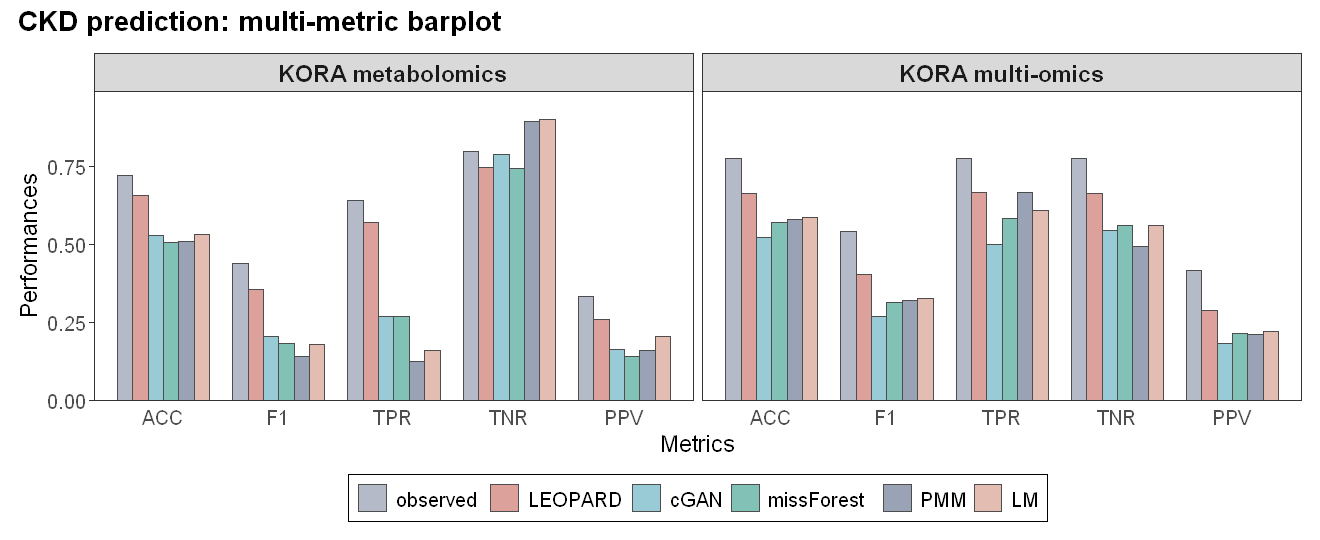

In [18]:
options(repr.plot.width = 11, repr.plot.height = 4.5)

# load multi-metric data
barPlot_data <- read.csv("data/plotData/caseStudy_classification_metrics.csv")
barPlot_data[["Data_source"]] <- factor(barPlot_data[["Data_source"]],
                                        levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))
barPlot_data[["Metric"]] <- factor(barPlot_data[["Metric"]],
                                   levels = c('Balanced Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'Precision'))

# generate bar plot
plot_bar <- ggplot(data = barPlot_data, aes(x = Metric, y = Performance, fill = Data_source)) +
    geom_bar(stat = "identity", position = position_dodge(), colour = "gray30", linewidth = 0.3, width = 0.8) +
    scale_fill_manual(values = colorspace::darken(c(
        pal_npg(alpha = 0.5)(9)[c(6)],
        pal_npg(alpha = 0.5)(5)), 0.18)
        ) +
    theme_bw() +
    scale_x_discrete(labels = c('Sensitivity' = 'TPR', 'Specificity' = 'TNR',
                                'Precision' = 'PPV', 'Balanced Accuracy' = 'ACC',
                                'F1 Score' = 'F1')) +
    scale_y_continuous(expand = expansion(c(0.0, 0.1))) +
    facet_wrap(~ Dataset, nrow = 1, scales = "fixed") +
    theme(legend.position    = 'bottom', 
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12, face = 'plain'),
          legend.title = element_blank(),
          legend.background = element_blank(),
          legend.box.background = element_rect(color = "black", linewidth = 0.25),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold")) +
    guides(fill = guide_legend(nrow = 1,byrow = TRUE)
    ) +
    labs(x = "Metrics", y = "Performances") +
    labs(colour = "DataSource")

plot_bar + plot_annotation(title = "CKD prediction: multi-metric barplot",
                           theme = theme(plot.title = element_text(size = 16, face = "bold")))

#### ROC curves

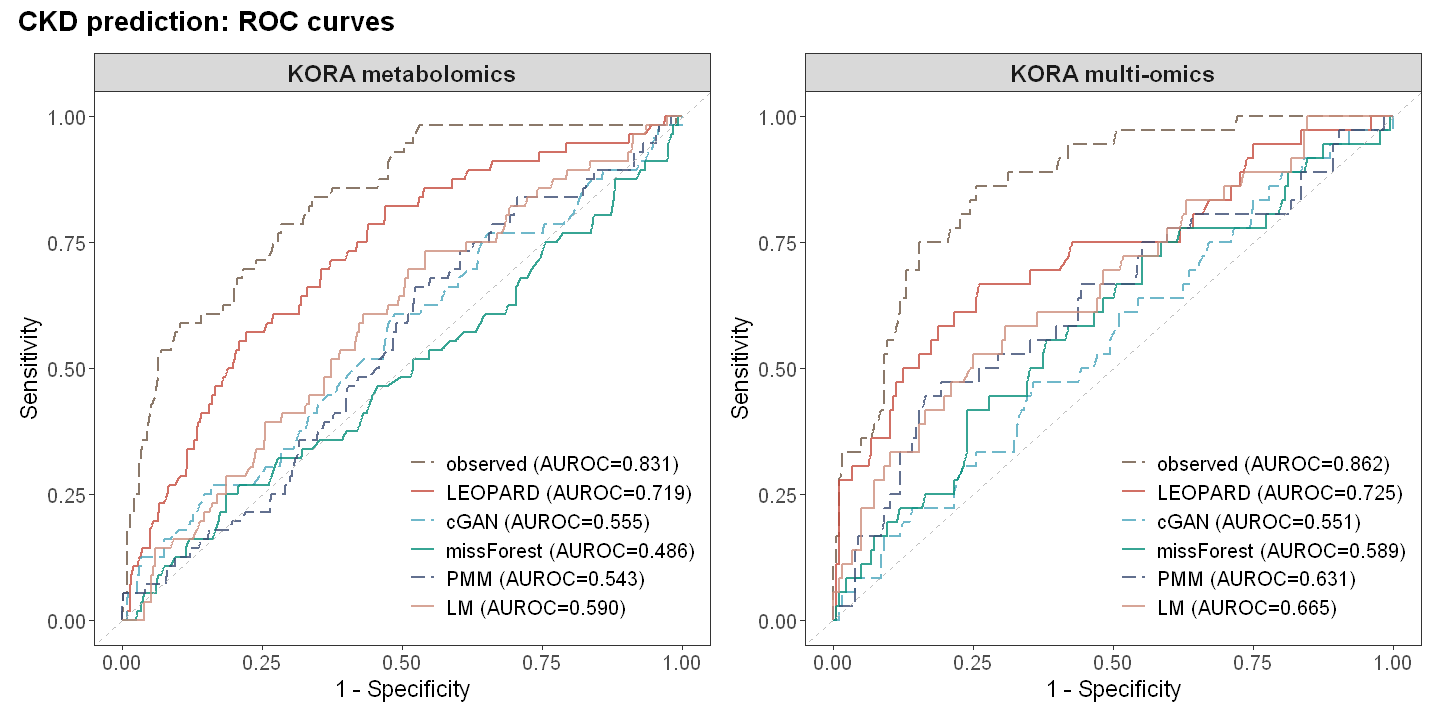

In [19]:
options(repr.plot.width = 12, repr.plot.height = 6)

# load ROC data
roc_data <- read.csv("data/plotData/caseStudy_classification_rocData.csv")

# set levels
roc_data[["Data_source"]] <- factor(roc_data[["Data_source"]],
                                    levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))

# split data for different datasets
roc_data_meta  <- roc_data[roc_data[["Dataset"]] == "KORA metabolomics",]
roc_data_multi <- roc_data[roc_data[["Dataset"]] == "KORA multi-omics",]

# set levels for AUROC labels
roc_data_meta[["AUROC_label"]] <- factor(roc_data_meta[["AUROC_label"]], 
                                         levels = roc_data_meta[["AUROC_label"]][
                                             match(levels(roc_data_meta[["Data_source"]]),
                                                   roc_data_meta[["Data_source"]])])

roc_data_multi[["AUROC_label"]] <- factor(roc_data_multi[["AUROC_label"]], 
                                          levels = roc_data_multi[["AUROC_label"]][
                                              match(levels(roc_data_multi[["Data_source"]]),
                                                    roc_data_multi[["Data_source"]])])
# generate ROC plot for KORA metabolomics dataset
plot_roc_meta <- ggplot(roc_data_meta, 
                        aes(x = x, y = y, color = AUROC_label, group = AUROC_label,
                            linetype = AUROC_label)) +
    geom_line(linewidth = 0.6) +
    geom_abline(linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "1 - Specificity", y = "Sensitivity", color = "Data source") +
    facet_wrap(~ Dataset, nrow = 1, scales = "fixed") +
    theme(legend.position = "inside",
          legend.position.inside = c(.75,.2),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold"))

# generate ROC plot for KORA multi-omics dataset
plot_roc_multi <- ggplot(roc_data_multi, 
                         aes(x = x, y = y, color = AUROC_label, group = AUROC_label,
                             linetype = AUROC_label)) +
    geom_line(linewidth = 0.6) +
    geom_abline(linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "1 - Specificity", y = "Sensitivity", color = "Data source") +
    facet_wrap(~ Dataset, nrow = 1, scales = "fixed") +
    theme(legend.position = "inside",
          legend.position.inside = c(.75,.2),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold")) 

plot_roc_meta + plot_roc_multi + plot_annotation(title = "CKD prediction: ROC curves",
                                                 theme = theme(plot.title = element_text(size = 16, face = "bold")))

#### PR curves

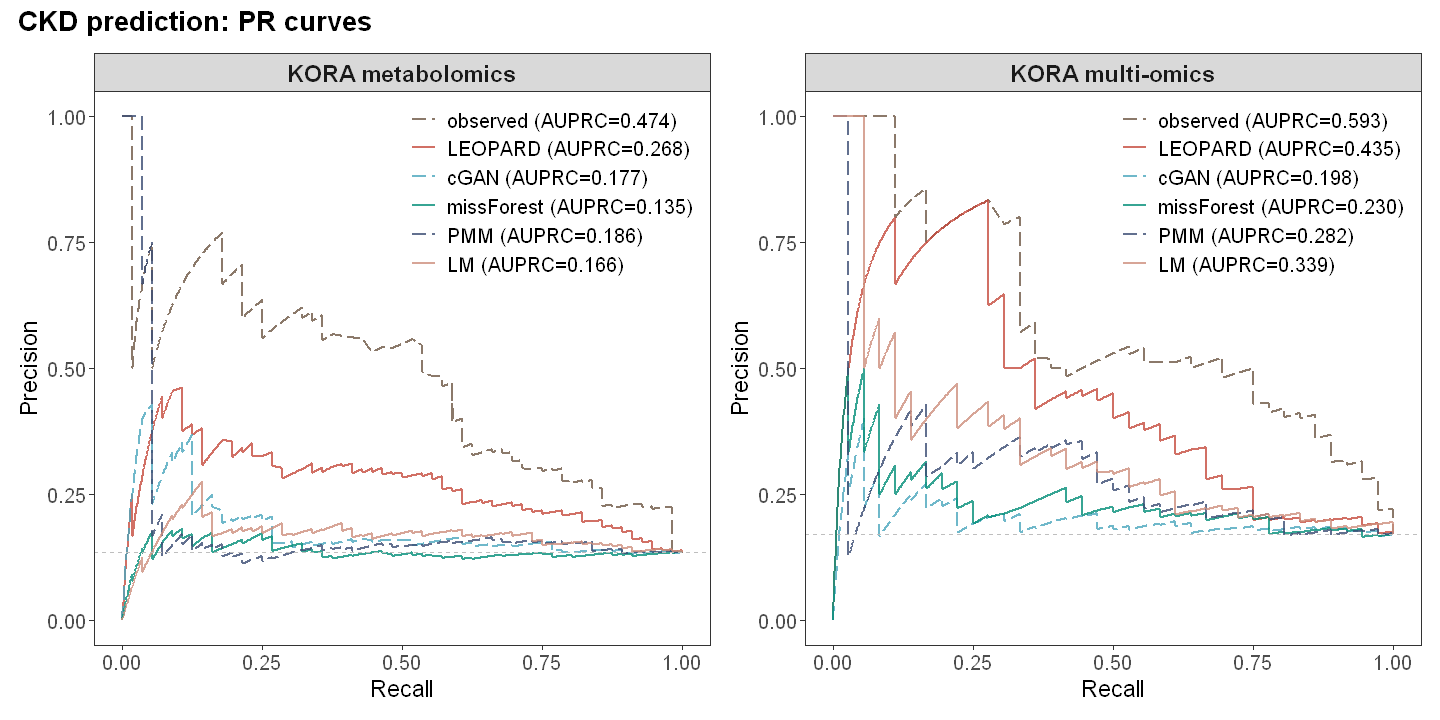

In [20]:
# load PRC data
prc_data <- read.csv("data/plotData/caseStudy_classification_prcData.csv")

# set levels
prc_data[["Data_source"]] <- factor(prc_data[["Data_source"]],
                                    levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))

# split data for different datasets
prc_data_meta  <- prc_data[prc_data[["Dataset"]] == "KORA metabolomics",]
prc_data_multi <- prc_data[prc_data[["Dataset"]] == "KORA multi-omics",]

# set levels for AUPRC labels
prc_data_meta[["AUPRC_label"]] <- factor(prc_data_meta[["AUPRC_label"]], 
                                         levels = prc_data_meta[["AUPRC_label"]][
                                             match(levels(prc_data_meta[["Data_source"]]),
                                                   prc_data_meta[["Data_source"]])])

prc_data_multi[["AUPRC_label"]] <- factor(prc_data_multi[["AUPRC_label"]], 
                                          levels = prc_data_multi[["AUPRC_label"]][
                                              match(levels(prc_data_multi[["Data_source"]]),
                                                    prc_data_multi[["Data_source"]])])

# generate PR curves for KORA metabolomics dataset
plot_prc_meta <- ggplot(prc_data_meta, 
                        aes(x = x, y = y, color = AUPRC_label, group = AUPRC_label,
                            linetype = AUPRC_label)) +
    geom_line(linewidth = 0.6) +
    geom_hline(yintercept = 56/416, linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "Recall", y = "Precision", color = "Data source") +
    facet_wrap(~ Dataset, nrow = 1, scales = "fixed") +
    theme(legend.position = "inside",
          legend.position.inside = c(.75,.82),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold"))

# generate PR curves for KORA multi-omics dataset
plot_prc_multi <- ggplot(prc_data_multi, 
                         aes(x = x, y = y, color = AUPRC_label, group = AUPRC_label,
                             linetype = AUPRC_label)) +
    geom_line(linewidth = 0.6) +
    geom_hline(yintercept = 36/212, linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "Recall", y = "Precision", color = "Data source") +
    facet_wrap(~ Dataset, nrow = 1, scales = "fixed") +
    theme(legend.position = "inside",
          legend.position.inside = c(.75,.82),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold")) 

plot_prc_meta + plot_prc_multi + plot_annotation(title = "CKD prediction: PR curves",
                                                 theme = theme(plot.title = element_text(size = 16, face = "bold")))

### 2.3 Case studies on the MGH COVID proteomics dataset

In this section, we generate plots corresponding to Fig. S11, which are based on the case studies performed on the MGH COVID proteomics dataset.

#### volcano plots for regression analysis

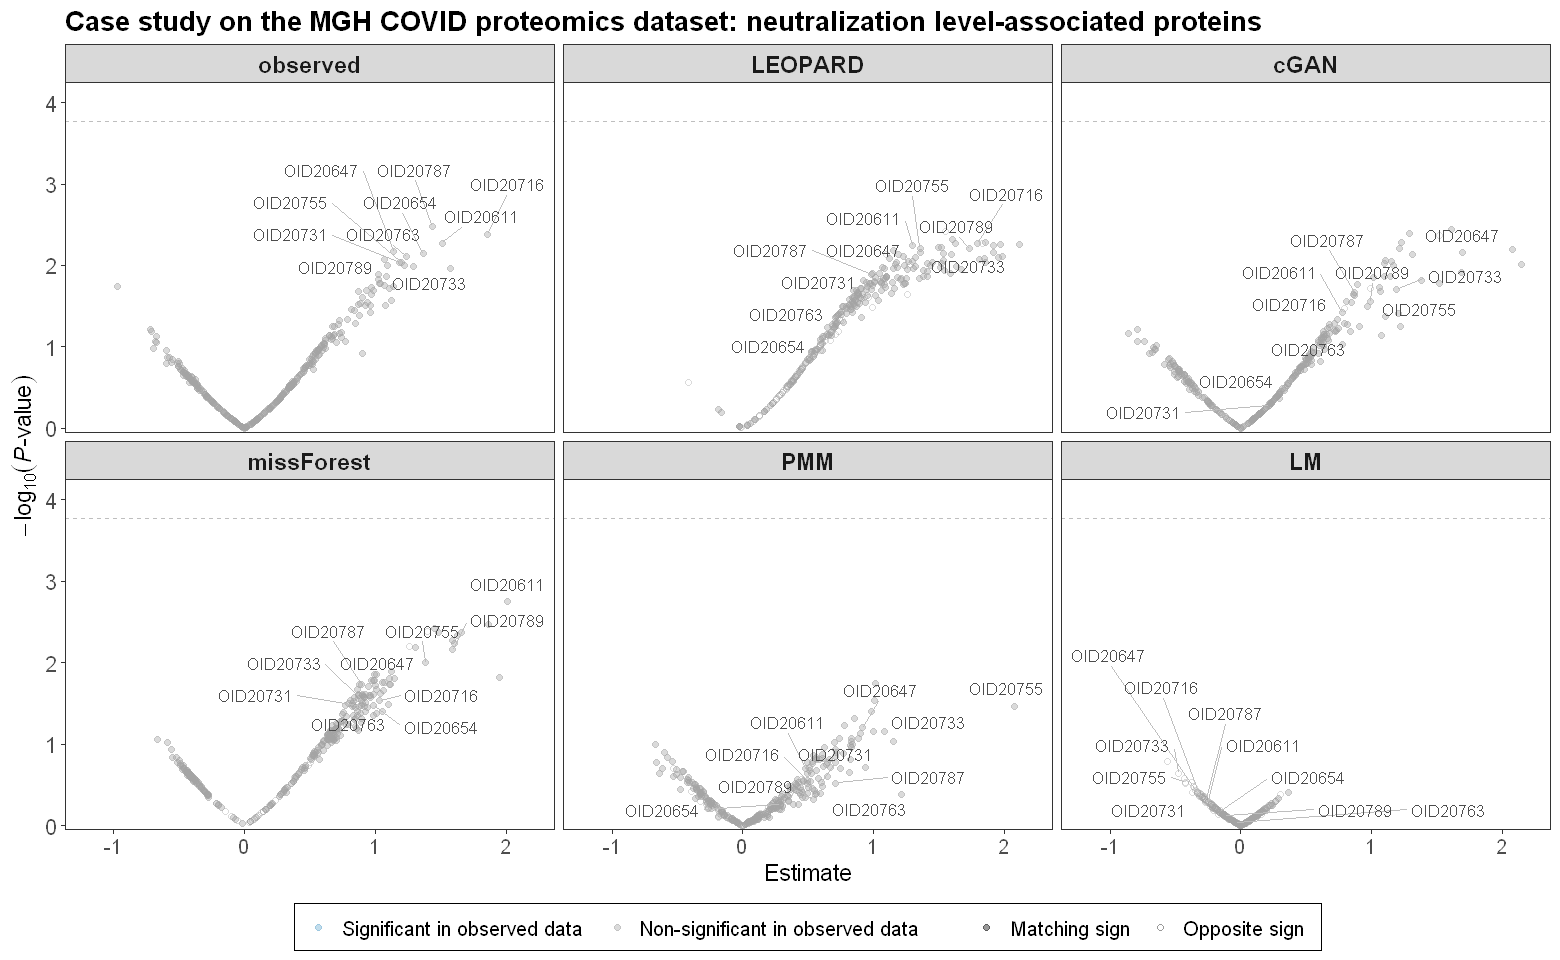

In [21]:
options(repr.plot.width = 13, repr.plot.height = 8)
options(ggrepel.max.overlaps = Inf)

# load estimate and P-val data
regression_mgh <- read.csv("data/plotData/caseStudy_mgh_regression.csv")
regression_mgh[["Method"]] <- factor(regression_mgh[["Method"]], 
                                     levels = c("observed", "LEOPARD", "cGAN", "missForest", "PMM", "LM"))
regression_mgh[["Bonferroni_observedData"]] <- factor(regression_mgh[["Bonferroni_observedData"]],
                                                      levels = c("Significant in observed data", 
                                                                 "Non-significant in observed data"))

# results from the observed data
observed_data <- regression_mgh[regression_mgh[["Method"]] == "observed",]
observed_data <- observed_data[order(observed_data[["P"]]),]

# As no significant variables were found in the observed data, 
# we highlight the variables with the top 10 lowest P-values.

# get variable with the top 10 lowest P-values:
variable_lowP <- observed_data[["Predictor"]][1:10]

# generate volcano plot
plot_volcano_mgh <- ggplot(regression_mgh, aes(x = Estimate, y = -log10(P), color = Bonferroni_observedData,
                                               label = Predictor)) +
    geom_point(alpha = I(0.4), size=1.5, aes(shape=factor(Sign_agreement)), show.legend=TRUE) +
    geom_hline(yintercept = (-log10(0.05/295)), linetype = 2, color = "grey") +
    scale_color_manual(values = c("#67a9cf", "#A3A3A3"), guide = guide_legend(order = 1), drop=FALSE) +
    scale_shape_manual(values = c(19,1)) +
    facet_wrap(~ Method, nrow = 2, scales = "fixed") +
    labs(x = "Estimate", y = expression(-log[10](italic("P")*textstyle("-")*value))) +
    geom_label_repel(data = regression_mgh[regression_mgh[["Predictor"]] %in% variable_lowP,],
                     size = 3.5, color = "grey30", box.padding = 0.2, label.padding = 0.2,
                     segment.color = 'gray', segment.size = 0.5,
                     nudge_y = 0.15, label.size = NA, fill = NA, ylim = c(0,8.5)) +
    scale_x_continuous(expand = c(0.05, 0), limits = c(-1.2, 2.2), breaks = seq(-1, 2, 1)) +
    scale_y_continuous(expand=c(0.0, 0.05), limits = c(0, 4.2)) +
    theme_bw() +
    theme(legend.position = 'bottom',
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          plot.title   = element_text(size = 16, face = "bold"),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 13),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12, face = 'plain'),
          strip.text   = element_text(size = 14, face = "bold"),
          legend.title = element_blank(),          
          legend.background = element_blank(),
          legend.box.background = element_rect(color = "black", linewidth = 0.25),
          legend.key = element_rect(fill = NA)) +
    ggtitle("Case study on the MGH COVID proteomics dataset: neutralization level-associated proteins")

plot_volcano_mgh

#### multi-metric barplot for neutralization level prediction

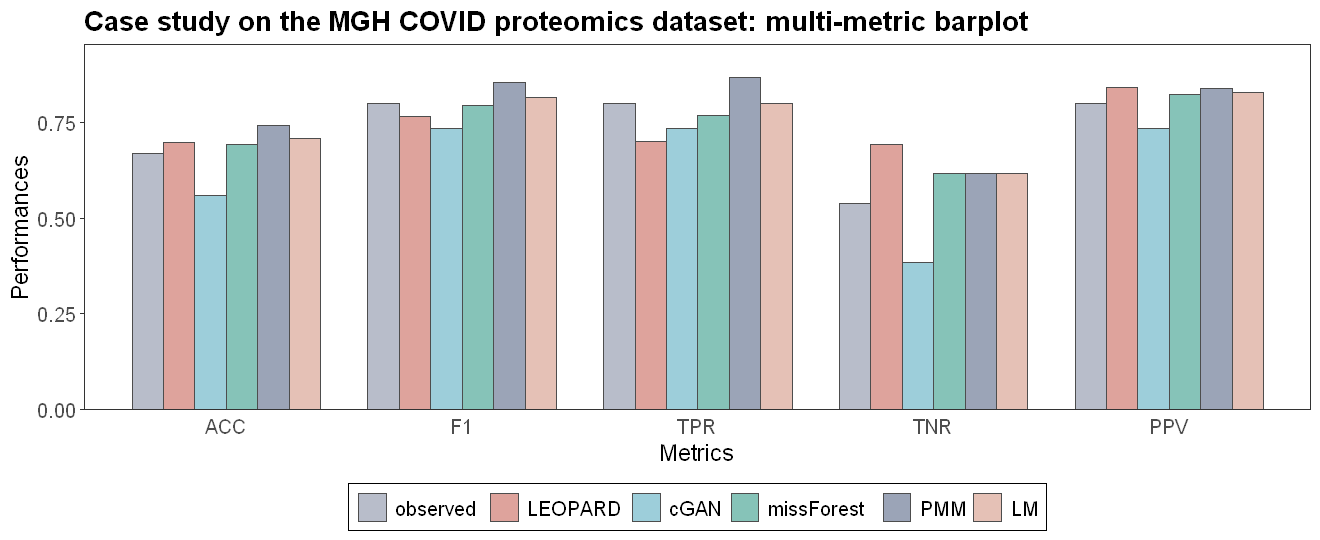

In [22]:
options(repr.plot.width = 11, repr.plot.height = 4.5)

# load multi-metric data
barPlot_mgh <- read.csv("data/plotData/caseStudy_mgh_classification_metrics.csv")

# set levels
barPlot_mgh[["Data_source"]] <- factor(barPlot_mgh[["Data_source"]],
                                       levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))
barPlot_mgh[["Metric"]] <- factor(barPlot_mgh[["Metric"]],
                                  levels = c('Balanced Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'Precision'))

# generate bar plot
plot_bar_mgh <- ggplot(data = barPlot_mgh, aes(x = Metric, y = Performance, fill = Data_source)) +
    geom_bar(stat = "identity", position = position_dodge(), colour = "gray30", linewidth = 0.3, width = 0.8) +
    scale_fill_manual(values = colorspace::darken(c(
        pal_npg(alpha = 0.5)(9)[6],
        pal_npg(alpha = 0.5)(5)), 0.15)
        ) +
    theme_bw() +
    scale_x_discrete(labels = c('Sensitivity' = 'TPR', 'Specificity' = 'TNR',
                                'Precision' = 'PPV', 'Balanced Accuracy' = 'ACC',
                                'F1 Score' = 'F1')) +
    scale_y_continuous(expand = expansion(c(0.0, 0.1))) +
    theme(legend.position    = 'bottom', 
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          legend.text  = element_text(size = 12, face = 'plain'),
          legend.title = element_blank(),
          legend.background = element_blank(),
          legend.box.background = element_rect(color = "black", linewidth = 0.25),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold"),
          plot.title = element_text(size = 16, face = "bold")) +
    guides(fill = guide_legend(nrow = 1,byrow = TRUE)) +
    labs(x = "Metrics", y = "Performances") +
    labs(colour = "DataSource") +
    ggtitle("Case study on the MGH COVID proteomics dataset: multi-metric barplot")

plot_bar_mgh

#### ROC curves and PR curves for neutralization level prediction

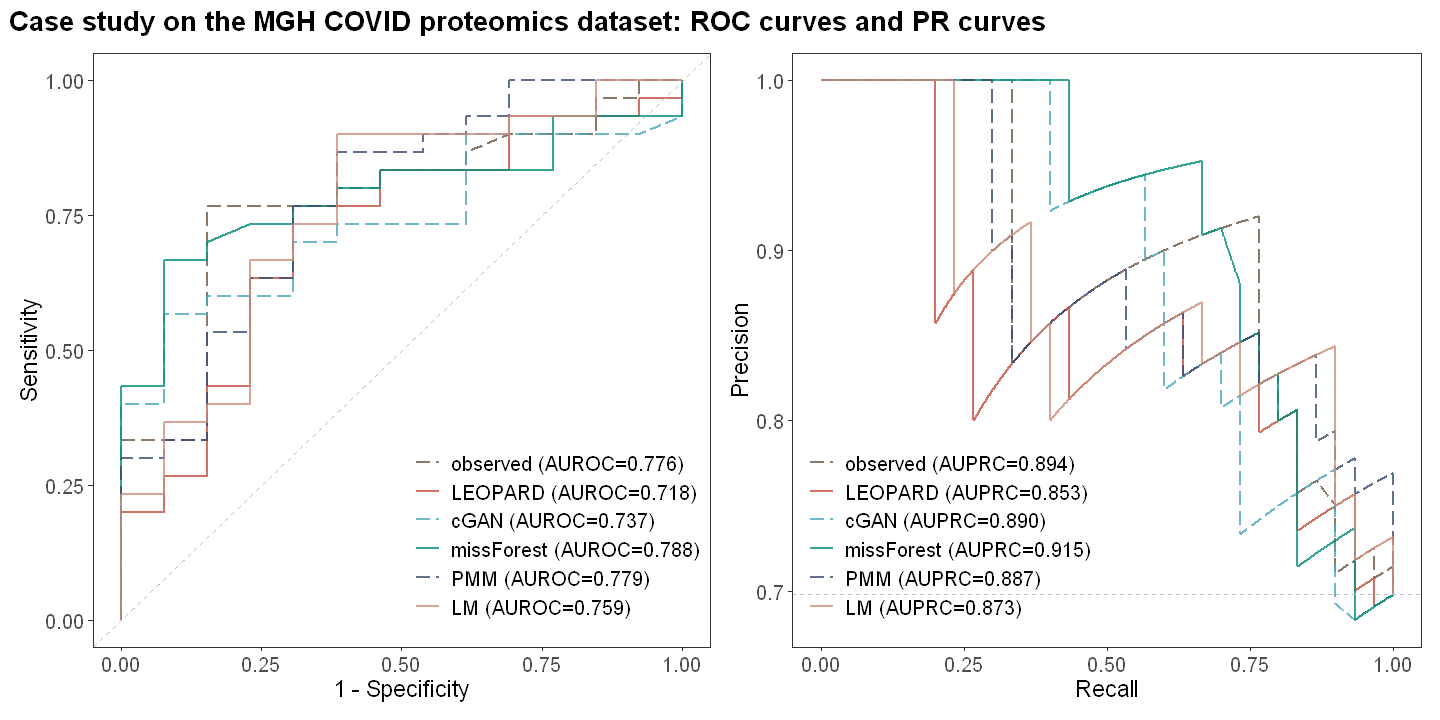

In [23]:
options(repr.plot.width = 12, repr.plot.height = 6)

# load ROC and PRC data
roc_data_mgh <- read.csv("data/plotData/caseStudy_mgh_classification_rocData.csv")
prc_data_mgh <- read.csv("data/plotData/caseStudy_mgh_classification_prcData.csv")

# set levels for data source
roc_data_mgh[["Data_source"]] <- factor(roc_data_mgh[["Data_source"]],
                                        levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))
prc_data_mgh[["Data_source"]] <- factor(prc_data_mgh[["Data_source"]],
                                        levels = c('observed', 'LEOPARD', 'cGAN', 'missForest', 'PMM', 'LM'))

# set levels for AUROC/PRAUC labels
roc_data_mgh[["AUROC_label"]] <- factor(roc_data_mgh[["AUROC_label"]], 
                                        levels = roc_data_mgh[["AUROC_label"]][
                                            match(levels(roc_data_mgh[["Data_source"]]),
                                                  roc_data_mgh[["Data_source"]])])

prc_data_mgh[["AUPRC_label"]] <- factor(prc_data_mgh[["AUPRC_label"]], 
                                        levels = prc_data_mgh[["AUPRC_label"]][
                                            match(levels(prc_data_mgh[["Data_source"]]),
                                                  prc_data_mgh[["Data_source"]])])

# generate ROC plot for MGH COVID proteomics dataset
plot_roc_mgh <- ggplot(roc_data_mgh, aes(x = x, y = y, color = AUROC_label, group = AUROC_label, linetype = AUROC_label)) +
    geom_line(linewidth = 0.6) +
    geom_abline(linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "1 - Specificity", y = "Sensitivity", color = "Data_source") +
    theme(legend.position = "inside",
          legend.position.inside = c(.75,.19),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold"))

# generate PR curves for MGH COVID proteomics dataset
plot_prc_mgh <- ggplot(prc_data_mgh, aes(x = x, y = y, color = AUPRC_label, group = AUPRC_label, linetype = AUPRC_label)) +
    geom_line(linewidth = 0.6) +
    geom_hline(yintercept = 30/43, linetype = "dashed", color = "gray") +
    scale_linetype_manual(values = c("longdash", "solid", "longdash", 
                                     "solid", "longdash", "solid"), name = "")+
    scale_color_manual(values = colorspace::darken(pal_npg("nrc", alpha = 0.8)(9)[c(9, 1:5)], 0.1), name = "") +
    theme_bw() +
    labs(x = "Recall", y = "Precision", color = "Data_source") +
    theme(legend.position = "inside",
          legend.position.inside = c(.25,.19),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x  = element_text(size = 12),
          axis.text.y  = element_text(size = 12),
          axis.title.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),  
          legend.text  = element_text(size = 12),
          legend.title = element_blank(),
          legend.background     = element_blank(),
          legend.box.background = element_blank(),
          legend.key = element_rect(fill = NA),
          strip.text = element_text(size = 14, face = "bold")) 

cowplot::plot_grid(plot_roc_mgh, plot_prc_mgh, nrow = 1) +
        plot_layout(guides = 'keep') + 
        plot_annotation(title = "Case study on the MGH COVID proteomics dataset: ROC curves and PR curves", 
                        theme = theme(plot.title = element_text(size = 16, face = "bold")))

## 3. Plots for applicability analyses

### 3.1 explore the minimum number of training samples

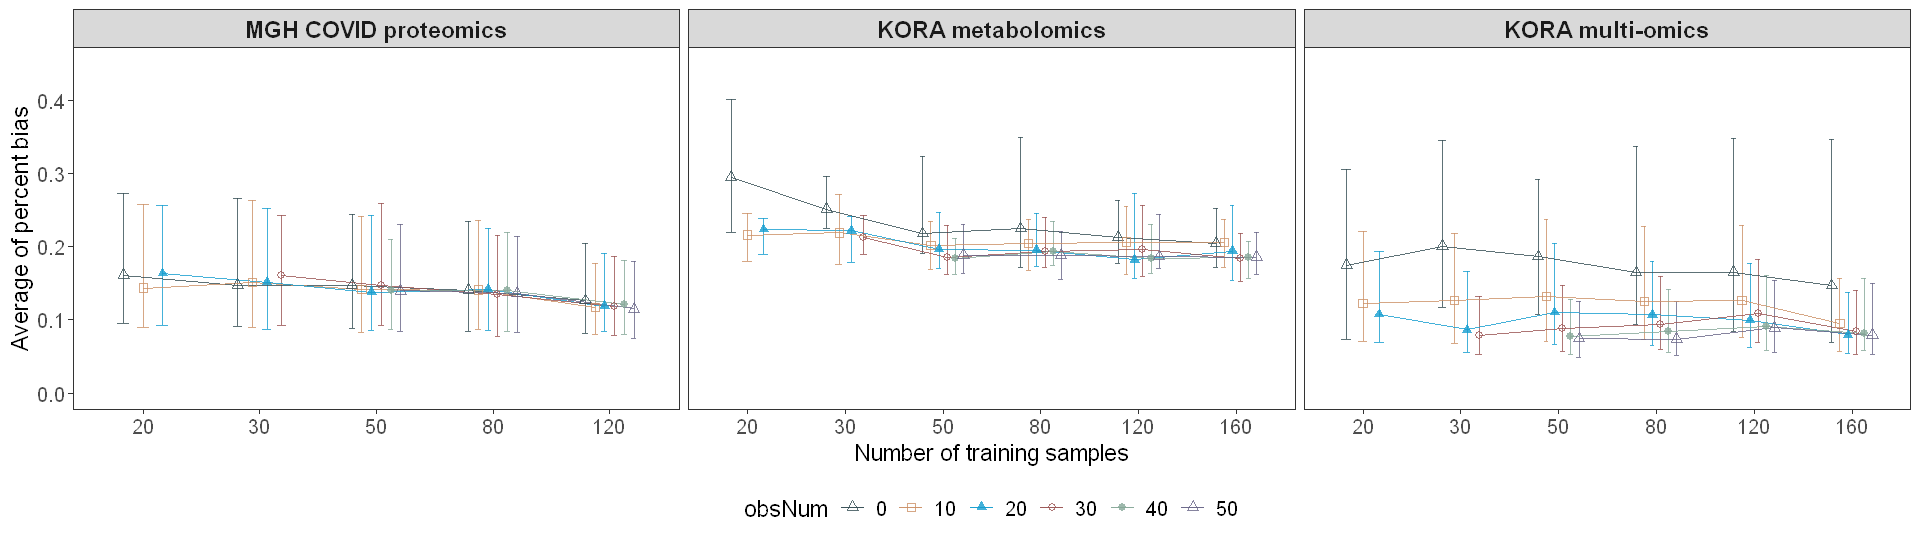

In [24]:
options(repr.plot.width = 16, repr.plot.height = 4.5)

# load summary data
summary_miniTrain <- read.csv("data/plotData/summary_miniTrain.csv")

# adjust factors
summary_miniTrain[["dataset"]] <- factor(summary_miniTrain[["dataset"]],
                                         levels = c("MGH COVID proteomics", "KORA metabolomics", "KORA multi-omics"))
summary_miniTrain[["trainNum"]] <- factor(summary_miniTrain[["trainNum"]])
summary_miniTrain[["obsNum"]]  <- factor(summary_miniTrain[["obsNum"]])

# generate plot, showing the 25th percentile, median, and the 75th percentile of PB
pd <- position_dodge(0.5)
plot_trainNum_overall <- ggplot(summary_miniTrain, aes(x = trainNum, y = median,
                                                       colour = obsNum, group = obsNum)) +
    geom_errorbar(aes(ymin = percentile.25th, ymax = percentile.75th),
                  width = .3, position = pd, linewidth = .5) +  # error bar in fact shows IQR 
    geom_line(position = pd, linewidth = 0.5, linetype = "solid") +
    geom_point(position = pd, size = 2, aes(shape = obsNum)) +
    scale_shape_manual(values = c(2, 0, 17, 1, 16, 2)) +
    scale_y_continuous(breaks = c(seq(0, 0.5, 0.1)), limits = c(0, 0.45)) +
    facet_grid(~ dataset, scales = "free") +
    theme_bw() +
    theme(legend.position = 'bottom',
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.title    = element_text(size = 16, face = "bold"),
          axis.text.x   = element_text(size = 12),
          axis.text.y   = element_text(size = 12),
          axis.title.y  = element_text(size = 14),
          axis.title.x  = element_text(size = 14),
          legend.text   = element_text(size = 12),
          legend.title  = element_text(size = 14),
          strip.text    = element_text(size = 14, face = "bold")) +
    guides(shape = guide_legend(nrow = 1)) +
    xlab("Number of training samples") +
    ylab("Average of percent bias") +
    scale_color_manual(values = colorspace::darken(pal_jama(alpha = 0.8)(6), 0.02))

plot_trainNum_overall

### 3.2 Aribitrary temporal knowledge transfer

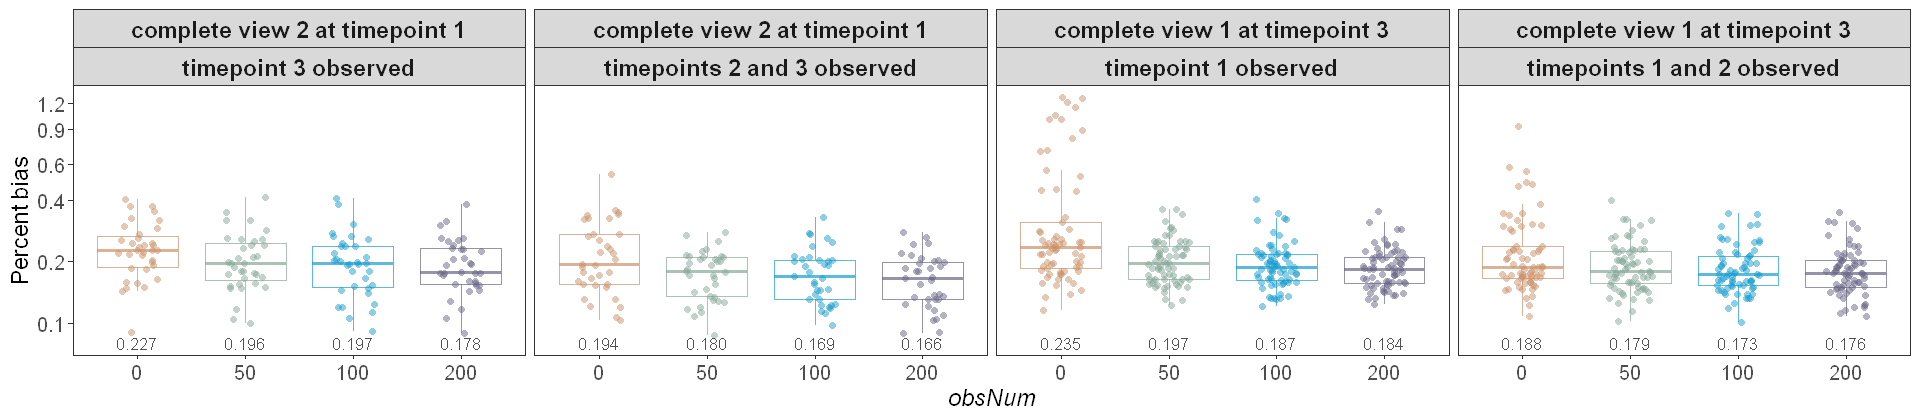

In [25]:
options(repr.plot.width = 16, repr.plot.height = 3.5)

# load PB values
arbitrary_data <- read.csv("data/plotData/evaluation_arbitraryTransfer.csv")

# adjust factors
arbitrary_data[["obsNum"]] <- factor(arbitrary_data[["obsNum"]])
arbitrary_data[["completion_task"]] <- factor(arbitrary_data[["completion_task"]], 
                                              levels = c("complete view 2 at timepoint 1", 
                                                         "complete view 1 at timepoint 3"))

# compute median value of each box
medians_arbitrary <- arbitrary_data %>% 
    group_by(completion_task, observed_timepoint, obsNum) %>%
    summarise(median_PB = median(PB, na.rm = TRUE), .groups = 'drop')

# generate boxplot for PB
boxplot_pb_arbitray <- ggplot(data = arbitrary_data, aes(x = obsNum,
                                                         y = PB,
                                                         colour = obsNum)) +
    geom_boxplot(alpha = I(0.3), outlier.colour = "black", 
                 outlier.shape = NA, notch = F) +
    # geom_violin(alpha = I(0.5), trim = F, colour = "gray", fill = NA, scale = "count") + # add violin plot?
    geom_jitter(alpha = I(0.5), shape = 16, width = 0.2) +
    geom_text(data = medians_arbitrary, aes(x = obsNum, y = 0.08, label = sprintf("%.3f", median_PB)),
              color = rgb(0.2, 0.2, 0.2, 0.85), size = 3.5, vjust = 0.5) +
    scale_y_continuous(trans = "log10", breaks = c(0.1, 0.2, 0.4, 0.6, 0.9, 1.2)) +
    facet_grid(~ completion_task + observed_timepoint, scales = "free") +
    theme_bw() +
    theme(legend.position = 'none',
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.title    = element_text(size = 16, face = "bold"),
          axis.text.x   = element_text(size = 12),
          axis.text.y   = element_text(size = 12),
          axis.title.y  = element_text(size = 14),
          axis.title.x  = element_text(size = 14, face = "italic"),
          legend.text   = element_text(size = 12),
          legend.title  = element_text(size = 14),
          strip.text    = element_text(size = 14, face = "bold")) +
    guides(col = guide_legend(nrow = 1)) +
    xlab("obsNum") +
    ylab("Percent bias") +
    scale_color_manual(values = colorspace::darken(pal_jama(alpha = 0.7)(6)[c(2,5,3,6)], 0.02))

boxplot_pb_arbitray